# マルチコンパートメントモデル
multi-compartment model

https://neuronaldynamics.epfl.ch/online/Ch3.S4.html

backprop-action potentialまで実装する．

In [1]:
using Parameters: @unpack # or using UnPack
using PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
@kwdef struct CompartmentHHParameter{FT}
    Cm::FT = 1
    gNa::FT = 120; gK::FT = 36; gL::FT = 0.3
    ENa::FT = 50; EK::FT = -77; EL::FT = -54
    gc::FT = 1.0  # 隣接区画との結合コンダクタンス (mS/cm^2)
end

@kwdef mutable struct MultiCompartmentHH{FT}
    num_compartments::Int
    dt::FT = 1e-3
    param::CompartmentHHParameter{FT} = CompartmentHHParameter{FT}()
    v::Vector{FT} = fill(-65, num_compartments)
    m::Vector{FT} = fill(0.05, num_compartments)
    h::Vector{FT} = fill(0.6, num_compartments)
    n::Vector{FT} = fill(0.32, num_compartments)
end

In [3]:
function update!(neuron::MultiCompartmentHH, Iext::Vector)
    @unpack num_compartments, dt, v, m, h, n = neuron
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, gc = neuron.param
    Vnext = copy(v) # 更新用の新しい電位ベクトル
    
    @inbounds for i = 1:num_compartments
        αm = 0.1 * (v[i]+40)/(1 - exp(-0.1*(v[i]+40)))
        βm = 4 * exp(-(v[i]+65)/18)
        αh = 0.07 * exp(-0.05*(v[i]+65))
        βh = 1 / (1 + exp(-0.1*(v[i]+35)))
        αn = 0.01 * (v[i]+55)/(1 - exp(-0.1*(v[i]+55)))
        βn = 0.125 * exp(-0.0125*(v[i]+65))

        m[i] += dt * (αm * (1 - m[i]) - βm * m[i])
        h[i] += dt * (αh * (1 - h[i]) - βh * h[i])
        n[i] += dt * (αn * (1 - n[i]) - βn * n[i])

        INa = gNa * m[i]^3 * h[i] * (v[i] - ENa)
        IK  = gK  * n[i]^4 * (v[i] - EK)
        IL  = gL  * (v[i] - EL)

        # 結合電流（隣接区画との拡散電流）
        I_coupling = zero(num_compartments)
        if i > 1
            I_coupling += gc * (v[i-1] - v[i])
        end
        if i < num_compartments
            I_coupling += gc * (v[i+1] - v[i])
        end

        Vnext[i] = v[i] + dt / Cm * (Iext[i] - INa - IK - IL + I_coupling)
    end
    neuron.v .= Vnext
    return Vnext
end

update! (generic function with 1 method)

In [43]:
N = 20
dt = 0.01
T = 100.0
steps = Int(T/dt)
Iext = zeros(Float64, N)
Iext[20] = 10.0  # 真ん中の区画に外部刺激

neuron = MultiCompartmentHH{Float64}(num_compartments=N, dt=dt)

MultiCompartmentHH{Float64}(20, 0.01, CompartmentHHParameter{Float64}(1.0, 120.0, 36.0, 0.3, 50.0, -77.0, -54.0, 1.0), [-65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6], [0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32])

In [34]:
vs = zeros(steps, N)
for t = 1:steps
    update!(neuron, Iext)
    vs[t, :] .= neuron.v
end

In [35]:
size(vs)

(10000, 20)

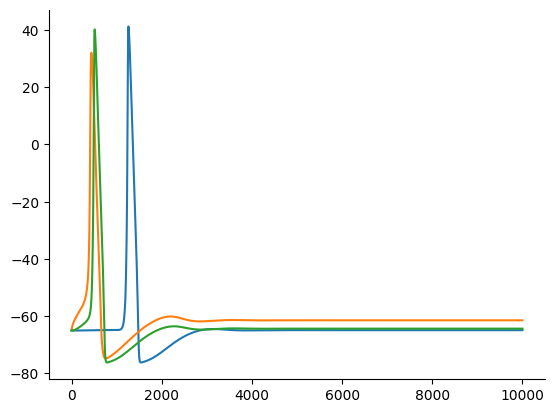

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000020B3C8022A0>

In [37]:
plot(vs[:, 1])
plot(vs[:, 18])
plot(vs[:, end])

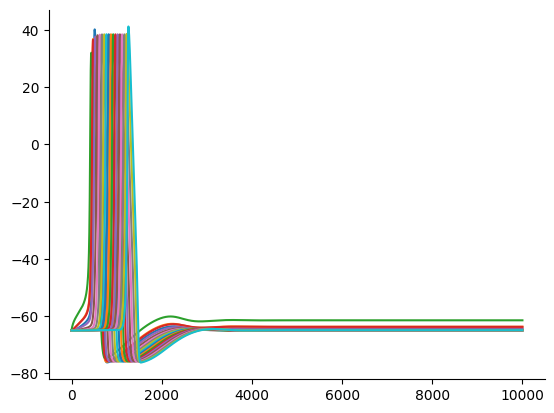

In [24]:
for i in 1:N
    plot(vs[:, i])
end

In [9]:
@kwdef mutable struct ActiveMultiCompartmentHH{FT}
    num_compartments::Int
    dt::FT = 1e-3
    param::CompartmentHHParameter{FT} = CompartmentHHParameter{FT}()
    v::Vector{FT} = fill(-65, num_compartments)
    m::Vector{FT} = fill(0.05, num_compartments)
    h::Vector{FT} = fill(0.6, num_compartments)
    n::Vector{FT} = fill(0.32, num_compartments)
    has_active_channels::Vector{Bool} = falses(num_compartments) # somaと一部dendriteでtrue
end

In [12]:
function update!(neuron::ActiveMultiCompartmentHH, Iext::Vector)
    @unpack num_compartments, dt, v, m, h, n, has_active_channels = neuron
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, gc = neuron.param
    Vnext = copy(v)
    
    @inbounds for i = 1:num_compartments
        # Leak成分・結合電流は常にある
        IL = gL * (v[i] - EL)
        I_coupling = zero(num_compartments)
        if i > 1; I_coupling += gc * (v[i-1] - v[i]); end
        if i < num_compartments; I_coupling += gc * (v[i+1] - v[i]); end

        # 活動成分（Na+, K+）はsomaや活性dendriteにのみ適用
        INa = IK = 0.0
        if has_active_channels[i]
            αm = 0.1 * (v[i]+40)/(1 - exp(-0.1*(v[i]+40)))
            βm = 4 * exp(-(v[i]+65)/18)
            αh = 0.07 * exp(-0.05*(v[i]+65))
            βh = 1 / (1 + exp(-0.1*(v[i]+35)))
            αn = 0.01 * (v[i]+55)/(1 - exp(-0.1*(v[i]+55)))
            βn = 0.125 * exp(-0.0125*(v[i]+65))

            m[i] += dt * (αm * (1 - m[i]) - βm * m[i])
            h[i] += dt * (αh * (1 - h[i]) - βh * h[i])
            n[i] += dt * (αn * (1 - n[i]) - βn * n[i])

            INa = gNa * m[i]^3 * h[i] * (v[i] - ENa)
            IK  = gK  * n[i]^4 * (v[i] - EK)
        end

        Vnext[i] = v[i] + dt / Cm * (Iext[i] - INa - IK - IL + I_coupling)
    end
    neuron.v .= Vnext
    return Vnext
end

update! (generic function with 2 methods)

In [38]:
neuron = ActiveMultiCompartmentHH{Float64}(num_compartments=N, dt=dt, has_active_channels=[true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, true])

ActiveMultiCompartmentHH{Float64}(20, 0.01, CompartmentHHParameter{Float64}(1.0, 120.0, 36.0, 0.3, 50.0, -77.0, -54.0, 1.0), [-65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -65.0], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6], [0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32], Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [39]:
length([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

20

In [40]:
vs = zeros(steps, N)
for t = 1:steps
    update!(neuron, Iext)
    vs[t, :] .= neuron.v
end

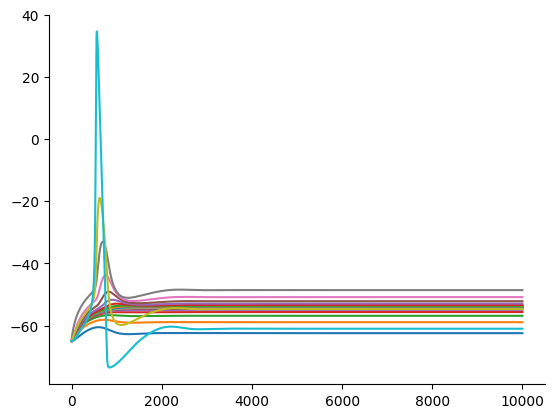

In [45]:
for i in 1:N
    plot(vs[:, i])
end